In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [2]:
def CalcABC(MOR, MOI, MSR, MSI, MLR, MLI):
    
    # Ideal load, open and short
    
    SOR = 1
    SOI = 0
    SSR = -1
    SSI = 0
    SLR = 0
    SLI = 0
       
    # Calculate coefficients
    
    K1R = MLR - MSR
    K1I = MLI - MSI
    K2R = MSR - MOR
    K2I = MSI - MOI
    K3R = MOR - MLR
    K3I = MOI - MLI

    K4R = K1R*(SLR*SSR-SLI*SSI) - K1I*(SLR*SSI+SLI*SSR)
    K4I = K1R*(SLR*SSI+SLI*SSR) + K1I*(SLR*SSR-SLI*SSI)

    K5R = K2R*(SOR*SSR-SOI*SSI) - K2I*(SOR*SSI+SOI*SSR)
    K5I = K2R*(SOR*SSI+SOI*SSR) + K2I*(SOR*SSR-SOI*SSI)

    K6R = K3R*(SLR*SOR-SLI*SOI) - K3I*(SLR*SOI+SLI*SOR)
    K6I = K3R*(SLR*SOI+SLI*SOR) + K3I*(SLR*SOR-SLI*SOI)

    K7R = SOR*K1R - SOI*K1I
    K7I = SOR*K1I + SOI*K1R

    K8R = SLR*K2R - SLI*K2I
    K8I = SLR*K2I + SLI*K2R

    K9R = SSR*K3R - SSI*K3I
    K9I = SSR*K3I + SSI*K3R

    DR = K4R + K5R + K6R
    DI = K4I + K5I + K6I

    AnumR = MOR*K7R - MOI*K7I + MLR*K8R - MLI*K8I + MSR*K9R - MSI*K9I
    AnumI = MOR*K7I + MOI*K7R + MLR*K8I + MLI*K8R + MSR*K9I + MSI*K9R

    BnumR = MOR*K4R - MOI*K4I + MLR*K5R - MLI*K5I + MSR*K6R - MSI*K6I
    BnumI = MOR*K4I + MOI*K4R + MLR*K5I + MLI*K5R + MSR*K6I + MSI*K6R

    CnumR = K7R + K8R + K9R
    CnumI = K7I + K8I + K9I

    AR = (AnumR*DR + AnumI*DI)/(DR*DR + DI*DI)
    AI = (AnumI*DR - AnumR*DI)/(DR*DR + DI*DI)

    BR = (BnumR*DR + BnumI*DI)/(DR*DR + DI*DI)
    BI = (BnumI*DR - BnumR*DI)/(DR*DR + DI*DI)

    CR = (CnumR*DR + CnumI*DI)/(DR*DR + DI*DI)
    CI = (CnumI*DR - CnumR*DI)/(DR*DR + DI*DI)

    return AR, AI, BR, BI, CR, CI


In [3]:
def ApplyCalibration(MMR, MMI, AR, AI, BR, BI, CR, CI):
    
    MAnumR = MMR - BR
    MAnumI = MMI - BI
    MAdenR = AR + CI*MMI - CR*MMR
    MAdenI = AI - CR*MMI - CI*MMR

    MAR = (MAnumR*MAdenR + MAnumI*MAdenI)/(MAdenR*MAdenR + MAdenI*MAdenI)
    MAI = (MAnumI*MAdenR - MAnumR*MAdenI)/(MAdenR*MAdenR + MAdenI*MAdenI)

    return MAR, MAI

In [4]:
def rotate(x, y, angle):
  angler = angle*np.pi/180
  newx = x*np.cos(angler) - y*np.sin(angler)
  newy = x*np.sin(angler) + y*np.cos(angler)
  return (newx, newy)

In [5]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

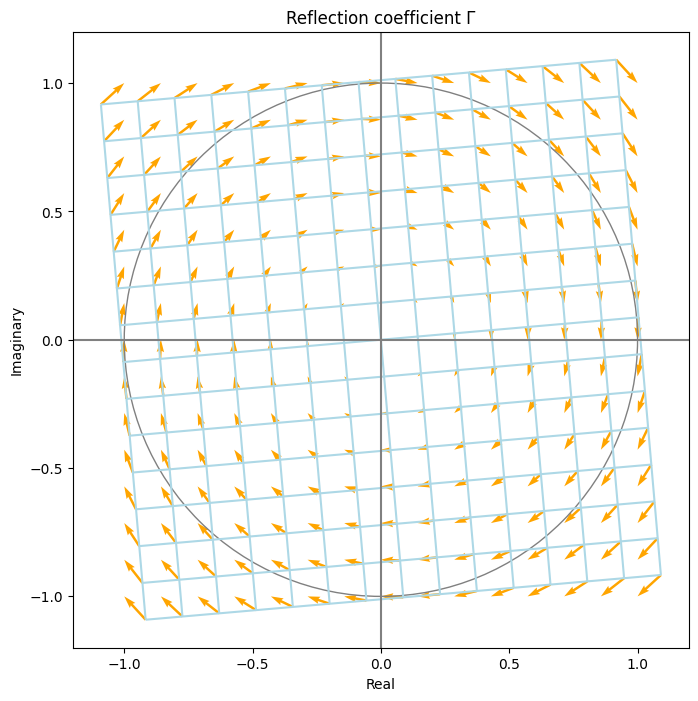

In [64]:
s = 1
p = 15
x = np.linspace(-s,s,p)
y = np.linspace(-s,s,p)
(x,y) = np.meshgrid(x,y)

mor, moi = 1, 0
msr, msi = -1, 0
mlr, mli = 0, 0

# mor += .3
# moi += .3

# mlr += .01 # SWR=1.02
# mlr += .05 # SWR=1.1
# mlr += .1 # SWR=1.22
# mlr += .2 # SWR=1.5
# mlr += .3 # SWR=2
# mlr += .5 # SWR=3

# mli += .1


angle = 5 # degrees

mor, moi = rotate(mor, moi, angle)
msr, msi = rotate(msr, msi, angle)
mlr, mli = rotate(mlr, mli, angle)

ar,ai,br,bi,cr,ci = CalcABC(mor,moi,msr,msi,mlr,mli)
u,v = ApplyCalibration(x,y,ar,ai,br,bi,cr,ci)

# plt.rcParams['figure.figsize'] = [10, 5]

fig, ax = plt.subplots()
plot_grid(x-(u-x),y-(v-y), ax=ax,  color="lightblue")
# plot_grid(x,y, ax=ax,  color="grey")

# u = u-x
# v = v-y

plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title("Reflection coefficient Γ")


# plt.quiver(x,y,u,v, angles='xy', scale_units='xy', scale=1.)
plt.quiver(x-(u-x),y-(v-y),u-x,v-y, angles='xy', scale_units='xy', scale=1., color='orange')

circle1 = plt.Circle((0, 0), 1, color='grey', fill = False)
plt.gca().add_patch(circle1)

plt.axhline(y=0, color='grey', linestyle='-')
plt.axvline(x=0, color='grey', linestyle='-')

plt.gca().set_aspect('equal')
plt.show()